## set running directory

In [1]:
from __future__ import print_function
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir


DATA_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "data")
try_mkdir(DATA_PATH)
MODEL_PATH = os.path.join(os.environ['RNB_PLANNING_DIR'], "model")
try_mkdir(MODEL_PATH)

GF_DATA_PATH = os.path.join(DATA_PATH, "gf3d")
try_mkdir(GF_DATA_PATH)
GF_MODEL_PATH = os.path.join(MODEL_PATH, "gf3d")
try_mkdir(GF_MODEL_PATH)

In [3]:
VISUALIZE = False

# ROBOT_TYPE = RobotType.indy7
# ROBOT_NAME = "indy0"
# TOOL_LINK = "indy0_tcp"
# TOOL_LINK_BUNDLE = ["indy0_tcp", "indy0_link6"]
# TOOL_XYZ = (0,0,0.14)
# GRIP_DEPTH = 0.05
# HOME_POSE = (0,0,0,0,0,0)

ROBOT_TYPE = RobotType.panda
ROBOT_NAME = "panda0"
TOOL_LINK = "panda0_hand"
TOOL_LINK_BUNDLE = ["panda0_hand", "panda0_link6"]
TOOL_XYZ = (0,0,0.112)
GRIP_DEPTH = 0.03
HOME_POSE = (0,-0.3,0,-0.5,0,2.5,0)


TOOL_RPY = (-np.pi/2,0,0)
CLEARANCE = 1e-3
TIMEOUT_REACH = 1
TIMEOUT_RETRIEVE = 3

assert TOOL_LINK_BUNDLE[0] == TOOL_LINK, "TOOL_LINK_BUNDLE should be in reverse order including actor's link as the first item"

## init combined robot config

In [4]:

from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, ROBOT_TYPE, None,
                None)]
              , connection_list=[False])
ROBOT_NAME = crob.robot_names[0]

connection command:
panda0: False


In [5]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None, base_link="base_link")
# s_builder.reset_reference_coord(ref_name="floor")

## get ghnd with detected robot config

In [6]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {ROBOT_NAME: ((0,0,0), (0,0,0))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob, start_rviz=VISUALIZE)
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)


In [7]:
from pkg.utils.joint_utils import get_tf
shoulder_link = gscene.urdf_content.joint_map[gscene.joint_names[1]].child
shoulder_height = get_tf(shoulder_link, HOME_DICT, gscene.urdf_content)[2,3]

## add environment

In [8]:
from pkg.geometry.geometry import *

In [9]:
gtems_robot = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True, exclude_link=["panda1_link7"])

## init planning scene

In [10]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

## Register binders

In [11]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [12]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name=TOOL_LINK, 
                 dims=(0.01,)*3, center=TOOL_XYZ, rpy=TOOL_RPY, color=(1,0,0,1), display=True, collision=False, fixed=True)
gripper = pscene.create_binder(bname="grip0", gname="grip0", _type=Gripper2Tool)

## planner

In [13]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
mplan = MoveitPlanner(pscene)

checkers=[]
gcheck = GraspChecker(pscene)
checkers.append(gcheck)
rcheck = ReachChecker(pscene)
checkers.append(rcheck)
# lcheck = LatticedChecker(pscene, gcheck)
# checkers.append(lcheck)
mplan.motion_filters = [gcheck]

## ui

In [14]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production


# Object Classes

In [15]:
from pkg.utils.gjk import get_point_list, get_gjk_distance
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask
from pkg.planning.filtering.pair_svm import get_pairwise_feature, get_step_dirYZ

PLANE_THICKNESS = 0.1
CLEARANCE = 1e-3

##
# @class ObstacleBase
# @brief base class for obstacle generators
class ObstacleBase:
    RTH_MIN = None ## R: center ~ nearest point
    RTH_MAX = None
    RPY_MIN = None
    RPY_MAX = None
    DIM_MIN = None
    DIM_MAX = None
    GTYPE = None
    COLOR = (0.7,0.7,0.7,1)
    
    def __init__(self, gscene, name, sampler=np.random.uniform, DIM=None, RTH=None, RPY=None):
        self.name = name
        self.DIM = sampler(self.DIM_MIN, self.DIM_MAX) if DIM is None else DIM
        self.RTH = sampler(self.RTH_MIN, self.RTH_MAX) if RTH is None else RTH
        self.RPY = sampler(self.RPY_MIN, self.RPY_MAX) if RPY is None else RPY
        self.RPY[2] += self.RTH[1]
        self.XYZ = np.array(cyl2cart(*self.RTH))
        verts_rotated = np.matmul(Rot_rpy(self.RPY), (DEFAULT_VERT_DICT[self.GTYPE]*self.DIM).transpose())
        xy_normed = self.XYZ[:2]/(np.linalg.norm(self.XYZ[:2])+1e-6)
        verts_r_compo = np.dot(xy_normed, verts_rotated[:2,:])
        self.XYZ[:2] -= xy_normed[:2]*np.min(verts_r_compo)
        self.RTH[0] -= np.min(verts_r_compo)
        self.geometry = gscene.create_safe(gtype=self.GTYPE, name=self.name, link_name="base_link", 
                                  dims=self.DIM, center=tuple(self.XYZ), rpy=self.RPY,
                                  color=self.COLOR, display=True, collision=True, fixed=True)
        self.subgeo_list = []
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_me, raddii_me = self.geometry.get_vertice_radius()
        verts_me_global = np.add(np.matmul(verts_me, self.geometry.orientation_mat.transpose()), 
                                 self.geometry.center)
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_me_global))-radii-raddii_me < 1e-4
        
##
# @class WorkPlane
# @brief working plane. target and obstacle objects are generated on this plane
class WorkPlane(ObstacleBase):
    RTH_MIN = (0.3, -np.pi/2, -0.2)
    RTH_MAX = (0.3, +np.pi/2, 0.5)
    RPY_MIN = (0, 0, -np.pi/6)
    RPY_MAX = (0, 0, +np.pi/6)
    DIM_MIN = (0.6, 0.6, PLANE_THICKNESS)
    DIM_MAX = (0.6, 0.6, PLANE_THICKNESS)
    GTYPE = GEOTYPE.BOX
    COLOR=  (0.8,0.8,0.2,0.5)
    
    def __init__(self, gscene, name, *args, **kwargs):
        ObstacleBase.__init__(self, gscene, name, *args, **kwargs)
        
    def is_overlapped_with(self, gtem):
        verts, radii = gtem.get_vertice_radius()
        verts_global = np.add(np.matmul(verts, gtem.orientation_mat.transpose()), gtem.center)
        verts_wp = np.multiply(DEFAULT_VERT_DICT[self.GTYPE], tuple(self.DIM[:2])+(self.H,))
        verts_wp_global = np.add(np.matmul(verts_wp, self.geometry.orientation_mat.transpose()), 
                                 np.add(self.geometry.center, (0,0,self.H/2)))
        return get_gjk_distance(get_point_list(verts_global), get_point_list(verts_wp_global))-radii < 1e-4
    
##
# @class PlaneObstacle
# @brief Obstacles on the workplane
class PlaneObject(ObstacleBase):
    RTH_MIN = (0.2, -np.pi/2, -0.2)
    RTH_MAX = (0.8, +np.pi/2, +0.5)
    RPY_MIN = (0, 0, 0)
    RPY_MAX = (0, 0, 0)
    DIM_MIN = (0.02, GRIP_DEPTH, GRIP_DEPTH)
    DIM_MAX = (0.055, 0.3, 0.3)
    GTYPE = GEOTYPE.BOX
    COLOR =  (0.2,0.2,0.8,0.5)
    def __init__(self, gscene, name, workplane, XYZ_LOC=None, **kwargs):
        ObstacleBase.__init__(self, gscene=gscene, name=name, **kwargs)
        verts, radii = self.geometry.get_vertice_radius()
        verts_rot = np.matmul(self.geometry.orientation_mat, verts.transpose()) ## verices with global orientaion
        verts_rot_loc = np.matmul(workplane.geometry.Toff[:3,:3].transpose(), verts_rot) ## verices with local orientaion
        max_verts = np.max(verts_rot_loc, axis=-1)
        min_verts = np.min(verts_rot_loc, axis=-1)
        if XYZ_LOC is None:
            self.XYZ_LOC = np.random.uniform(np.negative(workplane.DIM)/2-min_verts+radii,np.array(workplane.DIM)/2-max_verts-radii)
            self.XYZ_LOC[2] = workplane.DIM[2]/2 + self.DIM[2]/2 + CLEARANCE
        else:
            self.XYZ_LOC = self.XYZ_LOC
        self.XYZ = np.matmul(workplane.geometry.Toff[:3,:3], self.XYZ_LOC) + workplane.geometry.Toff[:3,3]
        self.RPY = (0,0,0)
        self.geometry.set_offset_tf(center = self.XYZ, orientation_mat=Rot_rpy(self.RPY))
        self.RTH = cart2cyl(*self.XYZ)
        gscene.update_marker(self.geometry)
        
        
def clear_class(gscene, key, Nmax):
    for iw in range(Nmax):
        gname = "{}_{}".format(key, iw)
        if gname in gscene.NAME_DICT:
            gscene.remove(gscene.NAME_DICT[gname])

            
def disperse_objects(gscene, object_class, key, Nobj, workplane_on):
    clear_class(gscene, key, Nobj)
        
    obs_list = []
    for iw in range(Nobj):
        while len(obs_list) != iw+1:
            obs = object_class(gscene, "{}_{}".format(key, iw), workplane_on)
            remove_this = False
            for obs_pre in obs_list:
                if obs_pre.is_overlapped_with(obs.geometry):
                    remove_this = True
                    break
            if remove_this:
                gscene.remove(obs.geometry)
            else:
                obs_list.append(obs)
    return obs_list


def add_object(pscene, obj, HANDLE_THICKNESS=1e-6, HANDLE_COLOR = (1,0,0,0.3)):
    gscene = pscene.gscene
    handles = []
    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_a", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_tp_b", link_name="base_link", 
                       dims=(obj.DIM[1], GRIP_DEPTH, HANDLE_THICKNESS), center=(0,0,obj.DIM[2]/2-GRIP_DEPTH/2), rpy=(np.pi/2,0,-np.pi/2), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_ft_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,obj.DIM[1]/2-GRIP_DEPTH/2,0), rpy=(0,-np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_a", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,-np.pi/2,0), 
                       color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                   parent=obj.name)
    )

    handles.append(
        gscene.create_safe(gtype=GEOTYPE.BOX, name="hdl_bk_b", link_name="base_link", 
                       dims=(obj.DIM[2], GRIP_DEPTH,HANDLE_THICKNESS), center=(0,-obj.DIM[1]/2+GRIP_DEPTH/2,0), rpy=(-np.pi,+np.pi/2,0), 
                           color=HANDLE_COLOR, display=True, collision=False, fixed=False,
                       parent=obj.name)
    )

    action_points_dict = {"placement": PlacePoint("placement", obj.geometry, [0,0,-obj.DIM[2]/2-CLEARANCE], [0,0,0])}
    action_points_dict.update({handle.name: Grasp2Point(handle.name, handle, (0,0,0), (0,0,0)) for handle in handles})
    obj_pscene = pscene.create_subject(oname=obj.name, gname=obj.name, _type=CustomObject, 
                                 action_points_dict=action_points_dict)
    return obj_pscene, handles

ROBOT_DATA_ROOT = os.path.join(GF_DATA_PATH, ROBOT_TYPE.name)
try_mkdir(ROBOT_DATA_ROOT)

   Use a production WSGI server instead.
 * Debug mode: off


# Dev GF3DSVM

In [16]:
from pkg.planning.filtering.pair_svm import PairSVM
pchecker = MoveitPlanner(pscene)
pchecker.motion_filters = [PairSVM(pscene)]
checkers = [pchecker]

In [17]:
print("Testing filters:")
for checker in checkers:
    for ft in checker.motion_filters:
        print("\t {}".format(ft.__class__.__name__))
    
print("Planner filters:")
for ft in mplan.motion_filters:
    print("\t {}".format(ft.__class__.__name__))

Testing filters:
	 PairSVM
Planner filters:
	 GraspChecker


## test 2 object

In [18]:
N_obj = 2
N_max_sample = 100
N_place = 2

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



1 / 100 in 8.19 / 818.51 s -- reach,retrieve = (0.0 %, 0.0 %, nan %)                     
2 / 100 in 19.42 / 971.05 s -- reach,retrieve = (33.3 %, 33.3 %, 50.0 %)                     
3 / 100 in 22.18 / 739.42 s -- reach,retrieve = (33.3 %, 33.3 %, 50.0 %)                     
4 / 100 in 22.23 / 555.76 s -- reach,retrieve = (25.0 %, 25.0 %, 50.0 %)                     
5 / 100 in 35.97 / 719.3 s -- reach,retrieve = (23.3 %, 23.3 %, 46.4 %)                     
6 / 100 in 46.94 / 782.35 s -- reach,retrieve = (23.6 %, 23.6 %, 44.1 %)                     
7 / 100 in 55.18 / 788.28 s -- reach,retrieve = (20.2 %, 20.2 %, 44.1 %)                     
8 / 100 in 65.47 / 818.37 s -- reach,retrieve = (17.7 %, 17.7 %, 44.1 %)                     
9 / 100 in 75.95 / 843.9 s -- reach,retrieve = (21.3 %, 21.3 %, 41.3 %)                     
10 / 100 in 86.25 / 862.52 s -- reach,retrieve = (19.2 %, 19.2 %, 41.3 %)                     
11 / 100 in 90.64 / 823.97 s -- reach,retrieve = (18.9 %, 18.9 %,

87 / 100 in 630.27 / 724.45 s -- reach,retrieve = (26.1 %, 26.1 %, 45.4 %)                     
88 / 100 in 639.89 / 727.15 s -- reach,retrieve = (25.9 %, 25.9 %, 45.3 %)                     
89 / 100 in 653.71 / 734.51 s -- reach,retrieve = (26.3 %, 26.3 %, 45.0 %)                     
90 / 100 in 665.29 / 739.21 s -- reach,retrieve = (26.2 %, 26.2 %, 44.7 %)                     
91 / 100 in 665.33 / 731.14 s -- reach,retrieve = (25.9 %, 25.9 %, 44.7 %)                     
92 / 100 in 675.61 / 734.36 s -- reach,retrieve = (25.6 %, 25.6 %, 44.7 %)                     
93 / 100 in 685.88 / 737.51 s -- reach,retrieve = (25.4 %, 25.4 %, 44.7 %)                     
94 / 100 in 695.53 / 739.93 s -- reach,retrieve = (25.3 %, 25.3 %, 44.7 %)                     
95 / 100 in 710.97 / 748.39 s -- reach,retrieve = (25.9 %, 25.9 %, 44.6 %)                     
96 / 100 in 722.51 / 752.62 s -- reach,retrieve = (26.0 %, 26.0 %, 44.5 %)                     
97 / 100 in 733.19 / 755.87 s -- reach,r

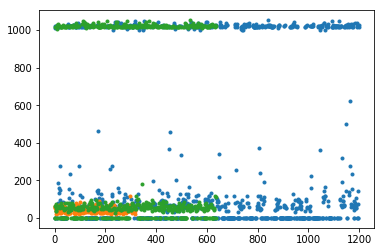

In [19]:
N_print = 10
SHOW_PERIOD = 0.01

i_s = 0
i_print = 0
filter_results_dict = defaultdict(list)
filter_time_dict = defaultdict(list)
filter_results_dict_place = defaultdict(list)

feature_time_list = []
reach_list = []
retrieve_list = []
place_list = []
gtimer = GlobalTimer.instance()
gtimer.reset(stack=True)
gtimer.tic("full_loop")
while i_s < N_max_sample:
    ## set workplane
    wp = WorkPlane(gscene, "wp")
    wp_pscene = pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", N_obj, workplane_on=wp)
    obj_names = [obj_tmp.name for obj_tmp in obj_list]

    obj = obj_list[0]
    obj_pscene, handles = add_object(pscene, obj)
    mplan.update_gscene()
    for rotate_obj in [False, True]:
        if rotate_obj:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
        else:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
        obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                    Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            
        for obj_tmp in obj_list[1:]:
            Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
            i_rot = random.choice([0,1])
            obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
            obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                     Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

        initial_state = pscene.initialize_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        from_state = initial_state.copy(pscene)
        to_node = ("grip0",)
        place_node = ("wp",)
        place_point = obj_pscene.action_points_dict['placement']
        for bp in sorted(obj_pscene.action_points_dict.keys()):
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
            handle = obj_pscene.action_points_dict[bp]
            if not gripper.check_type(handle):
                continue
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
            redundancy_dict['obj_0']['grip0']['w'] = 0
            redundancy_dict['obj_0'][bp]['w'] = 0
            redundancy_dict['obj_0'][bp]['x'] = 0
            redundancy_dict['obj_0'][bp]['y'] = 0
            redundancy_dict_pick = redundancy_dict
                        
            for checker in checkers:
                fname = []
                for ft in checker.motion_filters:
                    fname.append(ft.__class__.__name__)
                fname = "-".join(fname)
                gtimer.tic(fname)
                res = checker.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                etime = gtimer.toc(fname)
                filter_time_dict[fname].append(etime)
                filter_results_dict[fname].append(res)
                
            success_reach, success_retrieve, success_place = False, False, False
            with gtimer.block("reach"):
                Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
            
            Traj_retrieve = []
            if success_reach:
                if VISUALIZE:
                    gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                end_state = new_state.copy(pscene)
                end_state.Q = np.array(HOME_POSE)
                with gtimer.block("retrieve"):
                    Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                        from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                    
            if success_retrieve:
                if VISUALIZE:
                    gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
                    
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                
                for _ in range(N_place):
                    Traj_place = []
                    pscene.set_object_state(new_state)
                    to_state, redundancy_dict = pscene.sample_leaf_state(
                        new_state, {'obj_0': [('placement', 'wp', 'wp')]}, place_node)
                    
#                     print("=" * 37 + " PLACE " + "=" * 37)
                    
                    filter_result_tmp = []
                    for checker in checkers:
                        fname = []
                        for ft in checker.motion_filters:
                            fname.append(ft.__class__.__name__)
                        fname = "-".join(fname)
                        res = checker.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                        filter_results_dict_place[fname].append(res)
                        filter_result_tmp.append(res)
                        
                    with gtimer.block("place"):
                        Traj_place, LastQ, error, success_place, binding_list = mplan.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
                    place_list.append(success_place)
                    
                    if success_place:
                        if VISUALIZE:
                            gscene.show_motion(Traj_place, period=SHOW_PERIOD)
                            
                        for bd in binding_list:
                            pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                        binding_state, state_param = pscene.get_object_state()
                        tmp_state = State(binding_state, state_param, list(LastQ), pscene)
                        tmp_state.Q = crob.home_pose
                        for ftres, checker in zip(filter_result_tmp, checkers):
                            res = checker.plan_transition(
                                from_state=tmp_state, to_state=new_state, redundancy_dict=redundancy_dict_pick, test_filters_only=True)
                            if not res == ftres:
                                print("place-pick prediction mismatch")
#                         for obj_obs in obj_list:
#                             if obj_obs.geometry == obj_pscene.geometry:
#                                 continue
#                             Tobj = obj_pscene.geometry.get_tf(LastQ, from_link="panda0_link0")
#                             featurevec = get_pairwise_feature(
#                                 Tobj, 
#                                 obj_pscene.geometry.dims,
#                                 obj_obs.geometry, wp.geometry.Toff[2,3]+wp.geometry.dims[2]/2)
#                             print("ORIGINAL FEA {}: {}".format(obj_obs.geometry.name, np.round(featurevec, 2)))
#                             print("Tobj: \n {}".format(Tobj))
#                             print("Toff: \n {}".format(obj_pscene.geometry.Toff))
                    
#                     print("=" * 80)
                    
            pscene.set_object_state(from_state)
            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)
            
        pscene.set_object_state(initial_state)
        gscene.update_markers_all()
    i_s += 1
    gscene.update_markers_all()
    if i_s > 0 :
        if i_s > i_print*N_print:
            i_print +=  1
            print_end = "\n"
        else:
            print_end = "\r"
        time_elapsed = gtimer.toc("full_loop")/1000
        print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %, {} %)                     ".format(
            i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
            round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
            round(np.mean(place_list)*100, 1)))#, end=print_end)

time_elapsed = gtimer.toc("full_loop")/1000
print("")
print("")
print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %, {} %) =================".format(
    i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
    round(np.mean(place_list)*100, 1)))

import matplotlib.pyplot as plt
reach_time_log = gtimer.timelist_dict["reach"]
retrieve_time_log = gtimer.timelist_dict["retrieve"]
place_time_log = gtimer.timelist_dict["place"]
plt.plot(reach_time_log, '.')
plt.plot(retrieve_time_log, '.')
plt.plot(place_time_log, '.')

## test filter results

In [20]:
for checker in checkers:
    fname = []
    for ft in checker.motion_filters:
        fname.append(ft.__class__.__name__)
    fname = "-".join(fname)
    
    print("=" * 35 + " RETRIEVE " + "=" * 35)
    filter_results = filter_results_dict[fname]
    label_array_test = np.array(retrieve_list)
    test_res_all = np.equal(filter_results, label_array_test)
    filter_times = filter_time_dict[fname]
    print("{} accuracy ({}) = {} %".format(fname, len(test_res_all), round(np.mean(test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("-" * 80)
    print("{} time = {} ({}/{})ms".format(fname, round(np.mean(filter_times), 3), 
                                          round(np.min(filter_times), 3), round(np.max(filter_times), 3)))
    print("=" * 80)
    
    print("=" * 36 + " PLACE " + "=" * 37)
    filter_results = filter_results_dict_place[fname]
    label_array_test = place_list
    place_test_res_all = np.equal(filter_results, label_array_test)
    print("{} accuracy ({}) = {} %".format(fname, len(place_test_res_all), 
                                           round(np.mean(place_test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(place_test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(place_test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("=" * 80)

=================================== RETRIEVE ===================================
PairSVM accuracy (1200) = 87.67 %
PairSVM success accuracy (319) = 78.68 %
PairSVM failure accuracy (881) = 90.92 %
--------------------------------------------------------------------------------
PairSVM time = 1.219 (0.542/3.469)ms
==================================== PLACE =====================================
PairSVM accuracy (638) = 84.17 %
PairSVM success accuracy (281) = 85.05 %
PairSVM failure accuracy (357) = 83.47 %


## test 3 object

In [21]:
N_obj = 3
N_max_sample = 100
N_place = 2

1 / 100 in 10.28 / 1028.11 s -- reach,retrieve = (0.0 %, 0.0 %, nan %)                     
2 / 100 in 14.46 / 722.87 s -- reach,retrieve = (0.0 %, 0.0 %, nan %)                     
3 / 100 in 14.52 / 483.84 s -- reach,retrieve = (0.0 %, 0.0 %, nan %)                     
4 / 100 in 20.89 / 522.21 s -- reach,retrieve = (12.5 %, 12.5 %, 25.0 %)                     
5 / 100 in 31.59 / 631.8 s -- reach,retrieve = (21.7 %, 21.7 %, 30.8 %)                     
6 / 100 in 43.9 / 731.74 s -- reach,retrieve = (18.1 %, 18.1 %, 30.8 %)                     
7 / 100 in 43.95 / 627.91 s -- reach,retrieve = (15.5 %, 15.5 %, 30.8 %)                     
8 / 100 in 55.49 / 693.68 s -- reach,retrieve = (14.6 %, 14.6 %, 28.6 %)                     
9 / 100 in 56.55 / 628.32 s -- reach,retrieve = (16.7 %, 16.7 %, 41.7 %)                     
10 / 100 in 64.33 / 643.3 s -- reach,retrieve = (16.7 %, 16.7 %, 42.5 %)                     
11 / 100 in 71.23 / 647.58 s -- reach,retrieve = (20.5 %, 20.5 %, 46.3

87 / 100 in 570.07 / 655.26 s -- reach,retrieve = (28.9 %, 28.9 %, 37.9 %)                     
88 / 100 in 578.29 / 657.15 s -- reach,retrieve = (28.6 %, 28.6 %, 37.9 %)                     
89 / 100 in 586.52 / 659.01 s -- reach,retrieve = (28.3 %, 28.3 %, 37.9 %)                     
90 / 100 in 590.67 / 656.3 s -- reach,retrieve = (28.0 %, 28.0 %, 37.9 %)                     
91 / 100 in 596.34 / 655.32 s -- reach,retrieve = (28.0 %, 28.0 %, 37.7 %)                     
92 / 100 in 605.62 / 658.28 s -- reach,retrieve = (28.3 %, 28.3 %, 37.8 %)                     
93 / 100 in 605.65 / 651.24 s -- reach,retrieve = (28.0 %, 28.0 %, 37.8 %)                     
94 / 100 in 615.77 / 655.08 s -- reach,retrieve = (28.0 %, 28.0 %, 38.1 %)                     
95 / 100 in 624.02 / 656.86 s -- reach,retrieve = (27.7 %, 27.7 %, 38.1 %)                     
96 / 100 in 624.07 / 650.07 s -- reach,retrieve = (27.4 %, 27.4 %, 38.1 %)                     
97 / 100 in 634.63 / 654.26 s -- reach,re

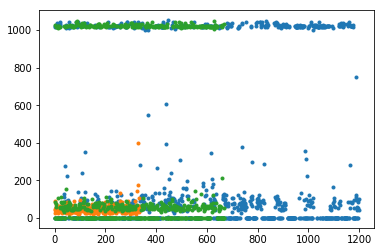

In [22]:
N_print = 10
SHOW_PERIOD = 0.01

i_s = 0
i_print = 0
filter_results_dict = defaultdict(list)
filter_time_dict = defaultdict(list)
filter_results_dict_place = defaultdict(list)

feature_time_list = []
reach_list = []
retrieve_list = []
place_list = []
gtimer = GlobalTimer.instance()
gtimer.reset(stack=True)
gtimer.tic("full_loop")
while i_s < N_max_sample:
    ## set workplane
    wp = WorkPlane(gscene, "wp")
    wp_pscene = pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", N_obj, workplane_on=wp)
    obj_names = [obj_tmp.name for obj_tmp in obj_list]

    obj = obj_list[0]
    obj_pscene, handles = add_object(pscene, obj)
    mplan.update_gscene()
    for rotate_obj in [False, True]:
        if rotate_obj:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
        else:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
        obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                    Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            
        for obj_tmp in obj_list[1:]:
            Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
            i_rot = random.choice([0,1])
            obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
            obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                     Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

        initial_state = pscene.initialize_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        from_state = initial_state.copy(pscene)
        to_node = ("grip0",)
        place_node = ("wp",)
        place_point = obj_pscene.action_points_dict['placement']
        for bp in sorted(obj_pscene.action_points_dict.keys()):
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
            handle = obj_pscene.action_points_dict[bp]
            if not gripper.check_type(handle):
                continue
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
            redundancy_dict['obj_0']['grip0']['w'] = 0
            redundancy_dict['obj_0'][bp]['w'] = 0
            redundancy_dict['obj_0'][bp]['x'] = 0
            redundancy_dict['obj_0'][bp]['y'] = 0
            redundancy_dict_pick = redundancy_dict
                        
            for checker in checkers:
                fname = []
                for ft in checker.motion_filters:
                    fname.append(ft.__class__.__name__)
                fname = "-".join(fname)
                gtimer.tic(fname)
                res = checker.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                etime = gtimer.toc(fname)
                filter_time_dict[fname].append(etime)
                filter_results_dict[fname].append(res)
                
            success_reach, success_retrieve, success_place = False, False, False
            with gtimer.block("reach"):
                Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
            
            Traj_retrieve = []
            if success_reach:
                if VISUALIZE:
                    gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                end_state = new_state.copy(pscene)
                end_state.Q = np.array(HOME_POSE)
                with gtimer.block("retrieve"):
                    Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                        from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                    
            if success_retrieve:
                if VISUALIZE:
                    gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
                    
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                
                for _ in range(N_place):
                    Traj_place = []
                    pscene.set_object_state(new_state)
                    to_state, redundancy_dict = pscene.sample_leaf_state(
                        new_state, {'obj_0': [('placement', 'wp', 'wp')]}, place_node)
                    
#                     print("=" * 37 + " PLACE " + "=" * 37)
                    
                    filter_result_tmp = []
                    for checker in checkers:
                        fname = []
                        for ft in checker.motion_filters:
                            fname.append(ft.__class__.__name__)
                        fname = "-".join(fname)
                        res = checker.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                        filter_results_dict_place[fname].append(res)
                        filter_result_tmp.append(res)
                        
                    with gtimer.block("place"):
                        Traj_place, LastQ, error, success_place, binding_list = mplan.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
                    place_list.append(success_place)
                    
                    if success_place:
                        if VISUALIZE:
                            gscene.show_motion(Traj_place, period=SHOW_PERIOD)
                            
                        for bd in binding_list:
                            pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                        binding_state, state_param = pscene.get_object_state()
                        tmp_state = State(binding_state, state_param, list(LastQ), pscene)
                        tmp_state.Q = crob.home_pose
                        for ftres, checker in zip(filter_result_tmp, checkers):
                            res = checker.plan_transition(
                                from_state=tmp_state, to_state=new_state, redundancy_dict=redundancy_dict_pick, test_filters_only=True)
                            if not res == ftres:
                                print("place-pick prediction mismatch")
#                         for obj_obs in obj_list:
#                             if obj_obs.geometry == obj_pscene.geometry:
#                                 continue
#                             Tobj = obj_pscene.geometry.get_tf(LastQ, from_link="panda0_link0")
#                             featurevec = get_pairwise_feature(
#                                 Tobj, 
#                                 obj_pscene.geometry.dims,
#                                 obj_obs.geometry, wp.geometry.Toff[2,3]+wp.geometry.dims[2]/2)
#                             print("ORIGINAL FEA {}: {}".format(obj_obs.geometry.name, np.round(featurevec, 2)))
#                             print("Tobj: \n {}".format(Tobj))
#                             print("Toff: \n {}".format(obj_pscene.geometry.Toff))
                    
#                     print("=" * 80)
                    
            pscene.set_object_state(from_state)
            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)
            
        pscene.set_object_state(initial_state)
        gscene.update_markers_all()
    i_s += 1
    gscene.update_markers_all()
    if i_s > 0 :
        if i_s > i_print*N_print:
            i_print +=  1
            print_end = "\n"
        else:
            print_end = "\r"
        time_elapsed = gtimer.toc("full_loop")/1000
        print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %, {} %)                     ".format(
            i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
            round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
            round(np.mean(place_list)*100, 1)))#, end=print_end)

time_elapsed = gtimer.toc("full_loop")/1000
print("")
print("")
print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %, {} %) =================".format(
    i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
    round(np.mean(place_list)*100, 1)))

import matplotlib.pyplot as plt
reach_time_log = gtimer.timelist_dict["reach"]
retrieve_time_log = gtimer.timelist_dict["retrieve"]
place_time_log = gtimer.timelist_dict["place"]
plt.plot(reach_time_log, '.')
plt.plot(retrieve_time_log, '.')
plt.plot(place_time_log, '.')

## test filter results

In [23]:
for checker in checkers:
    fname = []
    for ft in checker.motion_filters:
        fname.append(ft.__class__.__name__)
    fname = "-".join(fname)
    
    print("=" * 35 + " RETRIEVE " + "=" * 35)
    filter_results = filter_results_dict[fname]
    label_array_test = np.array(retrieve_list)
    test_res_all = np.equal(filter_results, label_array_test)
    filter_times = filter_time_dict[fname]
    print("{} accuracy ({}) = {} %".format(fname, len(test_res_all), round(np.mean(test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("-" * 80)
    print("{} time = {} ({}/{})ms".format(fname, round(np.mean(filter_times), 3), 
                                          round(np.min(filter_times), 3), round(np.max(filter_times), 3)))
    print("=" * 80)
    
    print("=" * 36 + " PLACE " + "=" * 37)
    filter_results = filter_results_dict_place[fname]
    label_array_test = place_list
    place_test_res_all = np.equal(filter_results, label_array_test)
    print("{} accuracy ({}) = {} %".format(fname, len(place_test_res_all), 
                                           round(np.mean(place_test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(place_test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(place_test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("=" * 80)

=================================== RETRIEVE ===================================
PairSVM accuracy (1200) = 84.25 %
PairSVM success accuracy (335) = 69.85 %
PairSVM failure accuracy (865) = 89.83 %
--------------------------------------------------------------------------------
PairSVM time = 1.189 (0.543/3.495)ms
==================================== PLACE =====================================
PairSVM accuracy (670) = 86.12 %
PairSVM success accuracy (251) = 80.88 %
PairSVM failure accuracy (419) = 89.26 %


## test 4 object

In [24]:
N_obj = 4
N_max_sample = 100
N_place = 2

1 / 100 in 10.23 / 1022.96 s -- reach,retrieve = (0.0 %, 0.0 %, nan %)                     
2 / 100 in 16.39 / 819.58 s -- reach,retrieve = (0.0 %, 0.0 %, nan %)                     
3 / 100 in 21.85 / 728.4 s -- reach,retrieve = (13.9 %, 13.9 %, 50.0 %)                     
4 / 100 in 33.87 / 846.83 s -- reach,retrieve = (18.8 %, 18.8 %, 33.3 %)                     
5 / 100 in 33.91 / 678.1 s -- reach,retrieve = (15.0 %, 15.0 %, 33.3 %)                     
6 / 100 in 37.52 / 625.29 s -- reach,retrieve = (16.7 %, 16.7 %, 29.2 %)                     
7 / 100 in 46.88 / 669.68 s -- reach,retrieve = (22.6 %, 22.6 %, 26.3 %)                     
8 / 100 in 46.92 / 586.53 s -- reach,retrieve = (19.8 %, 19.8 %, 26.3 %)                     
9 / 100 in 54.9 / 610.05 s -- reach,retrieve = (22.2 %, 22.2 %, 25.0 %)                     
10 / 100 in 64.27 / 642.74 s -- reach,retrieve = (24.2 %, 24.2 %, 32.8 %)                     
11 / 100 in 68.42 / 622.01 s -- reach,retrieve = (22.0 %, 22.0 %, 3

88 / 100 in 510.27 / 579.85 s -- reach,retrieve = (20.9 %, 20.9 %, 30.8 %)                     
89 / 100 in 517.26 / 581.2 s -- reach,retrieve = (21.4 %, 21.4 %, 31.2 %)                     
90 / 100 in 524.02 / 582.25 s -- reach,retrieve = (21.6 %, 21.6 %, 30.9 %)                     
91 / 100 in 532.24 / 584.88 s -- reach,retrieve = (21.3 %, 21.3 %, 30.9 %)                     
92 / 100 in 534.66 / 581.15 s -- reach,retrieve = (21.3 %, 21.3 %, 30.9 %)                     
93 / 100 in 539.1 / 579.68 s -- reach,retrieve = (21.2 %, 21.2 %, 30.8 %)                     
94 / 100 in 547.33 / 582.27 s -- reach,retrieve = (21.0 %, 21.0 %, 30.8 %)                     
95 / 100 in 547.39 / 576.2 s -- reach,retrieve = (20.8 %, 20.8 %, 30.8 %)                     
96 / 100 in 557.04 / 580.25 s -- reach,retrieve = (20.7 %, 20.7 %, 30.5 %)                     
97 / 100 in 564.74 / 582.2 s -- reach,retrieve = (20.7 %, 20.7 %, 30.5 %)                     
98 / 100 in 577.5 / 589.29 s -- reach,retrie

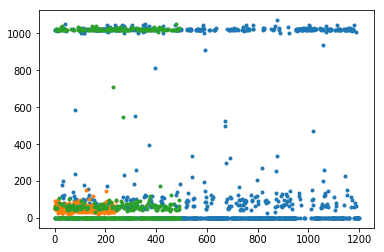

In [25]:
N_print = 10
SHOW_PERIOD = 0.01

i_s = 0
i_print = 0
filter_results_dict = defaultdict(list)
filter_time_dict = defaultdict(list)
filter_results_dict_place = defaultdict(list)

feature_time_list = []
reach_list = []
retrieve_list = []
place_list = []
gtimer = GlobalTimer.instance()
gtimer.reset(stack=True)
gtimer.tic("full_loop")
while i_s < N_max_sample:
    ## set workplane
    wp = WorkPlane(gscene, "wp")
    wp_pscene = pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", N_obj, workplane_on=wp)
    obj_names = [obj_tmp.name for obj_tmp in obj_list]

    obj = obj_list[0]
    obj_pscene, handles = add_object(pscene, obj)
    mplan.update_gscene()
    for rotate_obj in [False, True]:
        if rotate_obj:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
        else:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
        obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                    Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            
        for obj_tmp in obj_list[1:]:
            Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
            i_rot = random.choice([0,1])
            obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
            obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                     Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

        initial_state = pscene.initialize_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        from_state = initial_state.copy(pscene)
        to_node = ("grip0",)
        place_node = ("wp",)
        place_point = obj_pscene.action_points_dict['placement']
        for bp in sorted(obj_pscene.action_points_dict.keys()):
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
            handle = obj_pscene.action_points_dict[bp]
            if not gripper.check_type(handle):
                continue
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
            redundancy_dict['obj_0']['grip0']['w'] = 0
            redundancy_dict['obj_0'][bp]['w'] = 0
            redundancy_dict['obj_0'][bp]['x'] = 0
            redundancy_dict['obj_0'][bp]['y'] = 0
            redundancy_dict_pick = redundancy_dict
                        
            for checker in checkers:
                fname = []
                for ft in checker.motion_filters:
                    fname.append(ft.__class__.__name__)
                fname = "-".join(fname)
                gtimer.tic(fname)
                res = checker.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                etime = gtimer.toc(fname)
                filter_time_dict[fname].append(etime)
                filter_results_dict[fname].append(res)
                
            success_reach, success_retrieve, success_place = False, False, False
            with gtimer.block("reach"):
                Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
            
            Traj_retrieve = []
            if success_reach:
                if VISUALIZE:
                    gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                end_state = new_state.copy(pscene)
                end_state.Q = np.array(HOME_POSE)
                with gtimer.block("retrieve"):
                    Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                        from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                    
            if success_retrieve:
                if VISUALIZE:
                    gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
                    
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                
                for _ in range(N_place):
                    Traj_place = []
                    pscene.set_object_state(new_state)
                    to_state, redundancy_dict = pscene.sample_leaf_state(
                        new_state, {'obj_0': [('placement', 'wp', 'wp')]}, place_node)
                    
#                     print("=" * 37 + " PLACE " + "=" * 37)
                    
                    filter_result_tmp = []
                    for checker in checkers:
                        fname = []
                        for ft in checker.motion_filters:
                            fname.append(ft.__class__.__name__)
                        fname = "-".join(fname)
                        res = checker.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                        filter_results_dict_place[fname].append(res)
                        filter_result_tmp.append(res)
                        
                    with gtimer.block("place"):
                        Traj_place, LastQ, error, success_place, binding_list = mplan.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
                    place_list.append(success_place)
                    
                    if success_place:
                        if VISUALIZE:
                            gscene.show_motion(Traj_place, period=SHOW_PERIOD)
                            
                        for bd in binding_list:
                            pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                        binding_state, state_param = pscene.get_object_state()
                        tmp_state = State(binding_state, state_param, list(LastQ), pscene)
                        tmp_state.Q = crob.home_pose
                        for ftres, checker in zip(filter_result_tmp, checkers):
                            res = checker.plan_transition(
                                from_state=tmp_state, to_state=new_state, redundancy_dict=redundancy_dict_pick, test_filters_only=True)
                            if not res == ftres:
                                print("place-pick prediction mismatch")
#                         for obj_obs in obj_list:
#                             if obj_obs.geometry == obj_pscene.geometry:
#                                 continue
#                             Tobj = obj_pscene.geometry.get_tf(LastQ, from_link="panda0_link0")
#                             featurevec = get_pairwise_feature(
#                                 Tobj, 
#                                 obj_pscene.geometry.dims,
#                                 obj_obs.geometry, wp.geometry.Toff[2,3]+wp.geometry.dims[2]/2)
#                             print("ORIGINAL FEA {}: {}".format(obj_obs.geometry.name, np.round(featurevec, 2)))
#                             print("Tobj: \n {}".format(Tobj))
#                             print("Toff: \n {}".format(obj_pscene.geometry.Toff))
                    
#                     print("=" * 80)
                    
            pscene.set_object_state(from_state)
            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)
            
        pscene.set_object_state(initial_state)
        gscene.update_markers_all()
    i_s += 1
    gscene.update_markers_all()
    if i_s > 0 :
        if i_s > i_print*N_print:
            i_print +=  1
            print_end = "\n"
        else:
            print_end = "\r"
        time_elapsed = gtimer.toc("full_loop")/1000
        print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %, {} %)                     ".format(
            i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
            round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
            round(np.mean(place_list)*100, 1)))#, end=print_end)

time_elapsed = gtimer.toc("full_loop")/1000
print("")
print("")
print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %, {} %) =================".format(
    i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
    round(np.mean(place_list)*100, 1)))

import matplotlib.pyplot as plt
reach_time_log = gtimer.timelist_dict["reach"]
retrieve_time_log = gtimer.timelist_dict["retrieve"]
place_time_log = gtimer.timelist_dict["place"]
plt.plot(reach_time_log, '.')
plt.plot(retrieve_time_log, '.')
plt.plot(place_time_log, '.')

## test filter results

In [26]:
for checker in checkers:
    fname = []
    for ft in checker.motion_filters:
        fname.append(ft.__class__.__name__)
    fname = "-".join(fname)
    
    print("=" * 35 + " RETRIEVE " + "=" * 35)
    filter_results = filter_results_dict[fname]
    label_array_test = np.array(retrieve_list)
    test_res_all = np.equal(filter_results, label_array_test)
    filter_times = filter_time_dict[fname]
    print("{} accuracy ({}) = {} %".format(fname, len(test_res_all), round(np.mean(test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("-" * 80)
    print("{} time = {} ({}/{})ms".format(fname, round(np.mean(filter_times), 3), 
                                          round(np.min(filter_times), 3), round(np.max(filter_times), 3)))
    print("=" * 80)
    
    print("=" * 36 + " PLACE " + "=" * 37)
    filter_results = filter_results_dict_place[fname]
    label_array_test = place_list
    place_test_res_all = np.equal(filter_results, label_array_test)
    print("{} accuracy ({}) = {} %".format(fname, len(place_test_res_all), 
                                           round(np.mean(place_test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(place_test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(place_test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("=" * 80)

=================================== RETRIEVE ===================================
PairSVM accuracy (1200) = 86.0 %
PairSVM success accuracy (247) = 61.54 %
PairSVM failure accuracy (953) = 92.34 %
--------------------------------------------------------------------------------
PairSVM time = 1.295 (0.55/4.634)ms
==================================== PLACE =====================================
PairSVM accuracy (494) = 81.58 %
PairSVM success accuracy (151) = 74.17 %
PairSVM failure accuracy (343) = 84.84 %


## test 5 object

In [27]:
N_obj = 5
N_max_sample = 100
N_place = 2

1 / 100 in 7.87 / 786.8 s -- reach,retrieve = (33.3 %, 33.3 %, 50.0 %)                     
2 / 100 in 15.47 / 773.68 s -- reach,retrieve = (25.0 %, 25.0 %, 58.3 %)                     
3 / 100 in 16.3 / 543.35 s -- reach,retrieve = (27.8 %, 27.8 %, 50.0 %)                     
4 / 100 in 26.57 / 664.16 s -- reach,retrieve = (20.8 %, 20.8 %, 50.0 %)                     
5 / 100 in 26.6 / 532.05 s -- reach,retrieve = (16.7 %, 16.7 %, 50.0 %)                     
6 / 100 in 29.05 / 484.23 s -- reach,retrieve = (22.2 %, 22.2 %, 43.8 %)                     
7 / 100 in 33.75 / 482.17 s -- reach,retrieve = (22.6 %, 22.6 %, 42.1 %)                     
8 / 100 in 39.96 / 499.54 s -- reach,retrieve = (19.8 %, 19.8 %, 42.1 %)                     
9 / 100 in 42.99 / 477.62 s -- reach,retrieve = (23.1 %, 23.1 %, 38.0 %)                     
10 / 100 in 43.04 / 430.35 s -- reach,retrieve = (20.8 %, 20.8 %, 38.0 %)                     
11 / 100 in 57.65 / 524.12 s -- reach,retrieve = (22.0 %, 22.0 

87 / 100 in 485.9 / 558.51 s -- reach,retrieve = (20.9 %, 20.9 %, 24.8 %)                     
88 / 100 in 489.41 / 556.14 s -- reach,retrieve = (20.9 %, 20.9 %, 24.7 %)                     
89 / 100 in 498.52 / 560.13 s -- reach,retrieve = (21.1 %, 21.1 %, 24.2 %)                     
90 / 100 in 498.56 / 553.96 s -- reach,retrieve = (20.8 %, 20.8 %, 24.2 %)                     
91 / 100 in 503.12 / 552.88 s -- reach,retrieve = (20.8 %, 20.8 %, 24.2 %)                     
92 / 100 in 503.15 / 546.91 s -- reach,retrieve = (20.6 %, 20.6 %, 24.2 %)                     
93 / 100 in 505.23 / 543.26 s -- reach,retrieve = (20.3 %, 20.3 %, 24.2 %)                     
94 / 100 in 512.22 / 544.91 s -- reach,retrieve = (20.7 %, 20.7 %, 23.6 %)                     
95 / 100 in 519.3 / 546.63 s -- reach,retrieve = (21.1 %, 21.1 %, 22.9 %)                     
96 / 100 in 527.54 / 549.52 s -- reach,retrieve = (20.8 %, 20.8 %, 22.9 %)                     
97 / 100 in 531.68 / 548.12 s -- reach,ret

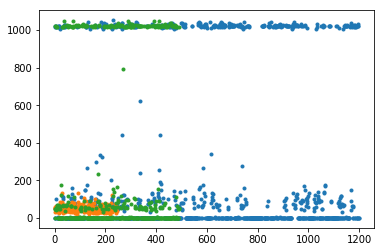

In [28]:
N_print = 10
SHOW_PERIOD = 0.01

i_s = 0
i_print = 0
filter_results_dict = defaultdict(list)
filter_time_dict = defaultdict(list)
filter_results_dict_place = defaultdict(list)

feature_time_list = []
reach_list = []
retrieve_list = []
place_list = []
gtimer = GlobalTimer.instance()
gtimer.reset(stack=True)
gtimer.tic("full_loop")
while i_s < N_max_sample:
    ## set workplane
    wp = WorkPlane(gscene, "wp")
    wp_pscene = pscene.create_binder(bname="wp", gname="wp", _type=PlacePlane)

    ## add object
    obj_list = disperse_objects(gscene, PlaneObject, "obj", N_obj, workplane_on=wp)
    obj_names = [obj_tmp.name for obj_tmp in obj_list]

    obj = obj_list[0]
    obj_pscene, handles = add_object(pscene, obj)
    mplan.update_gscene()
    for rotate_obj in [False, True]:
        if rotate_obj:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,np.pi/2))
        else:
            obj_pscene.geometry.set_offset_tf(orientation_mat=Rot_axis(3,0))
        obj_pscene.geometry.set_offset_tf(orientation_mat=np.matmul(obj_pscene.geometry.orientation_mat, 
                                                                    Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            
        for obj_tmp in obj_list[1:]:
            Rot_candis = [Rot_axis(3,np.pi/2), Rot_axis(3,0)]
            i_rot = random.choice([0,1])
            obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[i_rot])
            obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                     Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            if obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obj_tmp.geometry.set_offset_tf(orientation_mat=Rot_candis[(i_rot+1)%2])
                obj_tmp.geometry.set_offset_tf(orientation_mat=np.matmul(obj_tmp.geometry.orientation_mat, 
                                                                         Rot_axis(3,np.random.uniform(-np.pi/4, np.pi/4-1e-6))))
            while obj_tmp.is_overlapped_with(obj_pscene.geometry):
                obs = obj_tmp.__init__(gscene, obj_tmp.name, wp)

        initial_state = pscene.initialize_state(HOME_POSE)
        pscene.set_object_state(initial_state)
        from_state = initial_state.copy(pscene)
        to_node = ("grip0",)
        place_node = ("wp",)
        place_point = obj_pscene.action_points_dict['placement']
        for bp in sorted(obj_pscene.action_points_dict.keys()):
            pscene.set_object_state(initial_state)
            gscene.update_markers_all()
            handle = obj_pscene.action_points_dict[bp]
            if not gripper.check_type(handle):
                continue
            to_state, redundancy_dict = pscene.sample_leaf_state(from_state, {'obj_0': [(bp, 'grip0', 'grip0')]}, to_node)
            redundancy_dict['obj_0']['grip0']['w'] = 0
            redundancy_dict['obj_0'][bp]['w'] = 0
            redundancy_dict['obj_0'][bp]['x'] = 0
            redundancy_dict['obj_0'][bp]['y'] = 0
            redundancy_dict_pick = redundancy_dict
                        
            for checker in checkers:
                fname = []
                for ft in checker.motion_filters:
                    fname.append(ft.__class__.__name__)
                fname = "-".join(fname)
                gtimer.tic(fname)
                res = checker.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                etime = gtimer.toc(fname)
                filter_time_dict[fname].append(etime)
                filter_results_dict[fname].append(res)
                
            success_reach, success_retrieve, success_place = False, False, False
            with gtimer.block("reach"):
                Traj_reach, LastQ, error, success_reach, binding_list = mplan.plan_transition(
                    from_state=from_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
            
            Traj_retrieve = []
            if success_reach:
                if VISUALIZE:
                    gscene.show_motion(Traj_reach, period=SHOW_PERIOD)
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                end_state = new_state.copy(pscene)
                end_state.Q = np.array(HOME_POSE)
                with gtimer.block("retrieve"):
                    Traj_retrieve, LastQ, error, success_retrieve, binding_list = mplan.plan_transition(
                        from_state=new_state, to_state=end_state, timeout=TIMEOUT_RETRIEVE)
                    
            if success_retrieve:
                if VISUALIZE:
                    gscene.show_motion(Traj_retrieve, period=SHOW_PERIOD)
                    
                for bd in binding_list:
                    pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                binding_state, state_param = pscene.get_object_state()
                new_state = State(binding_state, state_param, list(LastQ), pscene)
                
                for _ in range(N_place):
                    Traj_place = []
                    pscene.set_object_state(new_state)
                    to_state, redundancy_dict = pscene.sample_leaf_state(
                        new_state, {'obj_0': [('placement', 'wp', 'wp')]}, place_node)
                    
#                     print("=" * 37 + " PLACE " + "=" * 37)
                    
                    filter_result_tmp = []
                    for checker in checkers:
                        fname = []
                        for ft in checker.motion_filters:
                            fname.append(ft.__class__.__name__)
                        fname = "-".join(fname)
                        res = checker.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, test_filters_only=True)
                        filter_results_dict_place[fname].append(res)
                        filter_result_tmp.append(res)
                        
                    with gtimer.block("place"):
                        Traj_place, LastQ, error, success_place, binding_list = mplan.plan_transition(
                            from_state=new_state, to_state=to_state, redundancy_dict=redundancy_dict, timeout=TIMEOUT_REACH)
                    place_list.append(success_place)
                    
                    if success_place:
                        if VISUALIZE:
                            gscene.show_motion(Traj_place, period=SHOW_PERIOD)
                            
                        for bd in binding_list:
                            pscene.rebind(bd, list2dict(LastQ, pscene.gscene.joint_names))
                        binding_state, state_param = pscene.get_object_state()
                        tmp_state = State(binding_state, state_param, list(LastQ), pscene)
                        tmp_state.Q = crob.home_pose
                        for ftres, checker in zip(filter_result_tmp, checkers):
                            res = checker.plan_transition(
                                from_state=tmp_state, to_state=new_state, redundancy_dict=redundancy_dict_pick, test_filters_only=True)
                            if not res == ftres:
                                print("place-pick prediction mismatch")
#                         for obj_obs in obj_list:
#                             if obj_obs.geometry == obj_pscene.geometry:
#                                 continue
#                             Tobj = obj_pscene.geometry.get_tf(LastQ, from_link="panda0_link0")
#                             featurevec = get_pairwise_feature(
#                                 Tobj, 
#                                 obj_pscene.geometry.dims,
#                                 obj_obs.geometry, wp.geometry.Toff[2,3]+wp.geometry.dims[2]/2)
#                             print("ORIGINAL FEA {}: {}".format(obj_obs.geometry.name, np.round(featurevec, 2)))
#                             print("Tobj: \n {}".format(Tobj))
#                             print("Toff: \n {}".format(obj_pscene.geometry.Toff))
                    
#                     print("=" * 80)
                    
            pscene.set_object_state(from_state)
            reach_list.append(success_reach)
            retrieve_list.append(success_retrieve)
            
        pscene.set_object_state(initial_state)
        gscene.update_markers_all()
    i_s += 1
    gscene.update_markers_all()
    if i_s > 0 :
        if i_s > i_print*N_print:
            i_print +=  1
            print_end = "\n"
        else:
            print_end = "\r"
        time_elapsed = gtimer.toc("full_loop")/1000
        print("{} / {} in {} / {} s -- reach,retrieve = ({} %, {} %, {} %)                     ".format(
            i_s, N_max_sample, round(time_elapsed, 2), round(time_elapsed/i_s*N_max_sample, 2), 
            round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
            round(np.mean(place_list)*100, 1)))#, end=print_end)

time_elapsed = gtimer.toc("full_loop")/1000
print("")
print("")
print("============= Finished {} in {} s -- reach,retrieve = ({} %, {} %, {} %) =================".format(
    i_s, round(time_elapsed, 2), round(np.mean(reach_list)*100, 1), round(np.mean(retrieve_list)*100, 1), 
    round(np.mean(place_list)*100, 1)))

import matplotlib.pyplot as plt
reach_time_log = gtimer.timelist_dict["reach"]
retrieve_time_log = gtimer.timelist_dict["retrieve"]
place_time_log = gtimer.timelist_dict["place"]
plt.plot(reach_time_log, '.')
plt.plot(retrieve_time_log, '.')
plt.plot(place_time_log, '.')

## test filter results

In [29]:
for checker in checkers:
    fname = []
    for ft in checker.motion_filters:
        fname.append(ft.__class__.__name__)
    fname = "-".join(fname)
    
    print("=" * 35 + " RETRIEVE " + "=" * 35)
    filter_results = filter_results_dict[fname]
    label_array_test = np.array(retrieve_list)
    test_res_all = np.equal(filter_results, label_array_test)
    filter_times = filter_time_dict[fname]
    print("{} accuracy ({}) = {} %".format(fname, len(test_res_all), round(np.mean(test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("-" * 80)
    print("{} time = {} ({}/{})ms".format(fname, round(np.mean(filter_times), 3), 
                                          round(np.min(filter_times), 3), round(np.max(filter_times), 3)))
    print("=" * 80)
    
    print("=" * 36 + " PLACE " + "=" * 37)
    filter_results = filter_results_dict_place[fname]
    label_array_test = place_list
    place_test_res_all = np.equal(filter_results, label_array_test)
    print("{} accuracy ({}) = {} %".format(fname, len(place_test_res_all), 
                                           round(np.mean(place_test_res_all) * 100, 2)))
    print("{} success accuracy ({}) = {} %".format(fname, int(np.sum(label_array_test)),
        round(np.mean(place_test_res_all[np.where(label_array_test)]) * 100, 2)))
    print("{} failure accuracy ({}) = {} %".format(fname, int(np.sum(np.logical_not(label_array_test))),
        round(np.mean(place_test_res_all[np.where(np.logical_not(label_array_test))]) * 100, 2)))
    print("=" * 80)

=================================== RETRIEVE ===================================
PairSVM accuracy (1200) = 86.42 %
PairSVM success accuracy (246) = 58.54 %
PairSVM failure accuracy (954) = 93.61 %
--------------------------------------------------------------------------------
PairSVM time = 1.37 (0.547/4.813)ms
==================================== PLACE =====================================
PairSVM accuracy (492) = 81.71 %
PairSVM success accuracy (115) = 74.78 %
PairSVM failure accuracy (377) = 83.82 %
